In [1]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import tempfile

np.random.seed(1337)

In [2]:
# load the mnist dataset
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join(tempfile.gettempdir(), hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.exists(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()


def cross_entropy_loss(predictions_Y, train_Y):
    predictions_count = predictions_Y.shape[0]
    scores = predictions_Y[range(predictions_count), train_Y]
    with np.errstate(divide='ignore'):
        log_likelihood = -np.where(scores > 0.00001, np.log(scores), np.log(np.full(scores.shape, 0.00001)))
        log_likelihood[np.isneginf(log_likelihood)] = -1e9
    return np.sum(log_likelihood) / predictions_count


class NNLayer(object):
    def __init__(self, size, activation_func='relu'):
        # self.W = np.random.randn(size[0], size[1]) * math.sqrt(2.0 / size[1])
        self.W = np.random.uniform(-1.0, 1.0, size) / np.sqrt(size[0] * size[1]).astype(np.float32)
        self.bias = np.random.random(size[0]) * 0.01
        self.activation_func = activation_func
        self.X = None
        self.Z = None
        self.Sigma = None
        self.dL_dW = None
        self.dL_dB = None
        self.delta_W = np.zeros(size) # Used to compute analytical gradient

    def forward(self, X):
        self.X = X
        self.Z = np.dot(self.X, (self.W + self.delta_W).T) + self.bias
        # Each row corresponds to an activation within the layer
        self.Sigma = self.apply_activation(self.Z)
        return self.Sigma

    def apply_activation(self, Z):
        if self.activation_func == 'relu':
            return np.maximum(0.0, Z)
        elif self.activation_func == 'cross_entropy_softmax':
            return np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
        else:
            return 0.0

    def backward(self, dL_dSigmas):
        # Each row in dL_dSigmas correspond to the derivative of the loss wrt. softmax's input
        # This is a batch operation that is done for all the neurons in the current layer
        dZ_dX = self.W + self.delta_W
        # Each row in X corresponds to a unique input in the batch
        dZ_dW = self.X
        dZ_dB = np.ones(self.bias.shape)

        if self.activation_func == 'cross_entropy_softmax':
            # dL_dSigmas actually refers to the derivative of the loss function wrt. the softmax input which is Z
            # So it is actually dL_dZ rather than dL_dSigmas
            dL_dZ = dL_dSigmas
        elif self.activation_func == 'relu':
            dL_dZ = dL_dSigmas
            dL_dZ[self.Z <= 0] = 0.0
        else:
            raise NameError('Unsupported activation function ' + self.activation_func)

        # dL_dW should be a matrix: each row corresponds to the derivative of the loss function wrt. the neuron's weights
        dL_dW = np.dot(dZ_dW.T, dL_dZ).T

        # dL_dB should a vector: each component correspond to the derivative of the loss function wrt. the neuron's bias
        dL_dB = np.sum(dL_dZ, axis=0) * dZ_dB

        # dL_dX should be a matrix: each row corresponds to the derivative of the loss function wrt. layer's input
        dL_dX = np.dot(dL_dZ, dZ_dX)

        assert dL_dX.shape == self.X.shape
        assert dL_dW.shape == self.W.shape
        assert dL_dB.shape == self.bias.shape

        self.dL_dW = dL_dW
        self.dL_dB = dL_dB
        return dL_dX

    def update(self, learning_rate, keep_gradients=False):
        self.W -= self.dL_dW * learning_rate
        self.bias -= self.dL_dB * learning_rate
        if keep_gradients == False:
            # Reinitialize accumulated derivatives `dL_dW` and `dL_dB`
            self.dL_dW = np.zeros(self.dL_dW.shape)
            self.dL_dB = np.zeros(self.dL_dB.shape)

    def set_delta_weights(self, neuron_index, input_index, delta):
        self.delta_W[neuron_index, input_index] = delta

class VanillaFCNN(object):

    def __init__(self, training_X, training_Y, input_output, keep_gradients=False):
        self.layers = []
        self.training_X = training_X
        self.training_Y = training_Y
        self.input_output = input_output
        self.keep_gradients = keep_gradients

    def addLayer(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def train(self, max_epoch, learning_rate, batch_size):
        t = trange(max_epoch)
        loss = 0.0
        for i in t:
            # Create batch
            sample = np.random.randint(0, self.training_X.shape[0], size=batch_size)
            batch_train_X = self.training_X[sample].reshape((-1, 28 * 28))
            batch_train_Y = self.training_Y[sample]

            predictions_Y = self.forward(batch_train_X)

            loss += cross_entropy_loss(predictions_Y, batch_train_Y)
            accuracy = np.mean(np.argmax(predictions_Y, axis=1) == batch_train_Y)

            # Backpropagation
            # Start with the derivative of the Loss function wrt. the softmax function's input
            dL_dZ = predictions_Y
            dL_dZ[range(batch_size), batch_train_Y] -= 1

            for layer in reversed(self.layers):
                dL_dZ = layer.backward(dL_dZ)
    
             # Update the weights
            for layer in self.layers:
                layer.update(learning_rate, self.keep_gradients)

            t.set_description(
                'Epoch %d / %d, Loss = %f, Accuracy = %.2f' % (i + 1, max_epoch, loss / (i + 1), accuracy.mean()))

    def __call__(self, input_index, learning_rate):
        batch_train_X = self.training_X[input_index].reshape((-1, 28 * 28))
        batch_train_Y = self.training_Y[input_index]
        
        predictions_Y = self.forward(batch_train_X)

        dL_dZ = predictions_Y
        dL_dZ[range(1), batch_train_Y] -= 1

        for layer in reversed(self.layers):
            dL_dZ = layer.backward(dL_dZ)
        
        # Update the weights
        for layer in self.layers:
            layer.update(learning_rate, self.keep_gradients)
        
    def predict(self, X):
        return self.forward(X.reshape(1, -1))

    def get_layer_gradient_matrix(self, layer_index):
        return self.layers[layer_index].dL_dW

    def compute_analytical_gradient(self, input_index, delta):
        sample_X = self.training_X[input_index].reshape(1, -1)
        sample_Y = self.training_Y[input_index]
        
        # Evaluate base loss
        predictions_Y = self.forward(sample_X)
        base_loss = cross_entropy_loss(predictions_Y, sample_Y)
        gradient = []
        
        for layer_index, layer in enumerate(self.layers):
            layer_neurons_count = layer.W.shape[0]
            layer_input_size = layer.W.shape[1]
            
            layer_gradients = np.zeros((layer_neurons_count, layer_input_size))
            for neuron_index in range(layer_neurons_count):
                for input_index in range(layer_input_size):
                    layer.set_delta_weights(neuron_index, input_index, delta)
            
                    predictions_Y = self.forward(sample_X)
                    loss = cross_entropy_loss(predictions_Y, sample_Y)
            
                    layer_gradients[neuron_index, input_index] = (loss - base_loss) / delta

                    # Reset delta weights
                    layer.set_delta_weights(neuron_index, input_index, 0.0)
                    
            gradient.append(layer_gradients)
        
        return gradient

In [3]:
def create_neural_network():
    X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape(-1, 28*28) / 255.0
    Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
    X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape(-1, 28, 28) / 255.0
    Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

    inputShapeSize = 784
    outputShapeSize = 10
    model = VanillaFCNN(training_X=X_train, training_Y=Y_train, input_output=(inputShapeSize, outputShapeSize), keep_gradients=True)
    model.addLayer(NNLayer((128, inputShapeSize), 'relu'))
    model.addLayer(NNLayer((outputShapeSize, 128), 'cross_entropy_softmax'))
    return model, X_test, Y_test


network_parameters = {'delta': 0.01, 'epochs': 1000, 'batch_size': 128}

model, X_test, Y_test = create_neural_network()
model.train(network_parameters['epochs'], network_parameters['delta'], network_parameters['batch_size'])

Epoch 1000 / 1000, Loss = 0.413388, Accuracy = 0.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.31it/s]


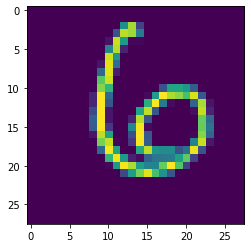

In [4]:
plt.imshow(X_test[100])

In [5]:
# Let's evaluate our model to check which number it thinks this image represents
model.predict(X_test[100]).argmax()

6

In [9]:
input_index = 0
# Gradient check
gradient_matrix = model.compute_analytical_gradient(input_index=0, delta=network_parameters['delta'])

-0.03808563977963624
0.04166770941846269


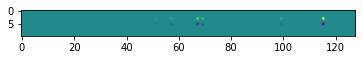

In [10]:
layer_index = 1
print(gradient_matrix[layer_index].min())
print(gradient_matrix[layer_index].max())
plt.imshow(gradient_matrix[layer_index])

-0.040897480918649705
0.040699497000275045


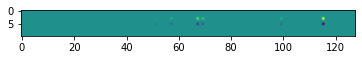

In [8]:
# Evaluate the model and do backward propagation on a single input
model(input_index=0, learning_rate=network_parameters['delta'])

layer_gradients = model.get_layer_gradient_matrix(layer_index)
print(layer_gradients.min())
print(layer_gradients.max())
plt.imshow(layer_gradients)